<a href="https://colab.research.google.com/github/vparonov/AIPlayground/blob/main/MagicDarts_2021_03_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import h5py
import numpy as np
import time
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [51]:
# enable / disable training of the single point predictor
train_the_single_point_predictor = False 

In [52]:
def getFullPath(fileName):
  return 'drive/MyDrive/darts_data/' + fileName

In [53]:
class MagicDartsDataset_SingleStep(Dataset):
    """
    Magic Darts Dataset
    For Single Step Prediction
    """

    def __init__(self, h5_files, transform=None):
        """
        Args:
            h5_file (string): Path to the h5 file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.f = [] 
        
        for h5_file in h5_files:
          self.f.append(h5py.File(h5_file,'r'))

        dshape = self.f[0]['cur_time'].shape
        self.dataShape = dshape[:-1]
        self.points_per_traj = dshape[-1]

        trajectory_count = 1 
        for s in self.dataShape:
          trajectory_count *= s

        self.trajectory_count = trajectory_count * len(h5_files)
       
        self.dataLen = self.trajectory_count * self.points_per_traj

        self.transform = transform
        
        self.x_keys =['cur_time', 'x_cur_clear', 'y_cur_clear', 'z_cur_clear',
                          'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear']

        self.preloaded = torch.empty(self.trajectory_count, self.points_per_traj, len(self.x_keys))

        for file_id, f in enumerate(self.f):
          for i, k in enumerate(self.x_keys):
            self.preloaded[file_id*trajectory_count:(file_id*trajectory_count + trajectory_count), :, i] = torch.tensor(f[k][:,:,:,:].reshape(trajectory_count, -1))

    def indexToDims(self, idx):
        traj_index = idx // self.points_per_traj
        traj_point_index = idx % self.points_per_traj
     
        #print(idx, traj_index, traj_point_index, self.points_per_traj)
        if traj_point_index < self.points_per_traj - 1:
          traj_point_index_yn = traj_point_index+1
        else:
          traj_point_index_yn = traj_point_index
  
        if traj_point_index > 0:
          traj_point_index_yp = traj_point_index- 1
        else:
          traj_point_index_yp = traj_point_index

        return traj_index, traj_point_index, traj_point_index_yp, traj_point_index_yn

    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):
   
        
        traj, xix, ypix, ynix = self.indexToDims(idx)

        x_keys = self.x_keys
        
        y = torch.empty(2 * len(self.x_keys))

        x = self.preloaded[traj, xix, :]

        nix = len(self.x_keys)
        y[0:nix] = self.preloaded[traj, ypix, :]
        y[nix:]  = self.preloaded[traj, ynix, :]
        
        sample = {'x': x, 'y': y, 'traj_ix':traj}

        if self.transform:
            sample = self.transform(sample)
          
        return sample

In [54]:
class MagicDartsDataset(Dataset):
    """Magic Darts Dataset"""

    def __init__(self, h5_files, noise=True, transform=None):
        """
        Args:
            h5_file (string): Path to the h5 file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.f = [] 
        
        for h5_file in h5_files:
          self.f.append(h5py.File(h5_file,'r'))

        dshape = self.f[0]['cur_time'].shape
        self.dataShape = dshape[:-1]
        self.timeDimSize = dshape[-1]

        nitems = 1 
        for s in self.dataShape:
          nitems *= s

        self.dataLen = nitems * len(h5_files)
        self.noise = noise 

        self.transform = transform
        
        if (noise == True):
          self.x_keys = ['cur_time', 
                        'x_hat_0', 'y_hat_0', 'z_hat_0',
                        'vx_cur_esti','vy_cur_esti','vz_cur_esti']
        else:
          self.x_keys =['cur_time', 'x_cur_clear', 'y_cur_clear', 'z_cur_clear',
                  'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear']



        self.y_keys = ['t_hit', 'x_results_real','y_results_real','z_results_real', 
                       'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear' ]

        x_preloaded = torch.empty(self.dataLen, self.timeDimSize, len(self.x_keys))
        y_preloaded = torch.empty(self.dataLen, 1, len(self.y_keys))

        for file_id, f in enumerate(self.f):
          for i, k in enumerate(self.x_keys):
            x_preloaded[file_id*nitems:(file_id*nitems + nitems), :, i] = torch.tensor(f[k][:,:,:,:].reshape(nitems, -1))

          for i, k in enumerate(self.y_keys):
            y_preloaded[file_id*nitems:(file_id*nitems + nitems), 0, i] = torch.tensor(f[k][:,:,:,-1].reshape(nitems))

        self.preloaded = torch.hstack((x_preloaded, y_preloaded))
        
    def getDataLen(self):
        return self.dataLen

    def indexToDims(self, idx):
      return idx 

    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):

        traj_ix = self.indexToDims(idx)

        x = self.preloaded[traj_ix,:-1,:]
        y = self.preloaded[traj_ix,-1,(1, 3)]

        sample = {'x':x, 'y': y, 'traj_ix': traj_ix}

        if self.transform:
            sample = self.transform(sample)
          
        return sample

In [75]:
ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_1_cut_share.h5'), 
                                   getFullPath('input_para_2021_03_10_file_2_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_3_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_4_cut_share.h5')])

print(len(ds))
dp = ds[124]

x = dp['x']
y = dp['y']
traj_ix = dp['traj_ix']




24000


In [55]:
class StepPredictor(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(StepPredictor, self).__init__()

    self.input_size = input_size

    self.net = nn.Sequential(
      #nn.BatchNorm1d(7),
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, input_size * 2)
      )

  def forward(self,x):
    return self.net(x)

  def predict(self, x):
    with torch.no_grad():
      outputs = self.forward(x)
      return outputs[:,:self.input_size], outputs[:,self.input_size:]

In [52]:
ds = MagicDartsDataset_SingleStep([getFullPath('input_para_2021_03_10_file_1_cut_share.h5'), 
                                   getFullPath('input_para_2021_03_10_file_2_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_3_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_4_cut_share.h5')])

              
train_size = int(0.90 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

print(len(train_dataset), len(test_dataset))

batch_size = 5000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


1123200 124800


In [53]:
learning_rate = 0.0001 

model = StepPredictor(input_size = 7, hidden_size = 128)

criterion = torch.nn.MSELoss()    # mean-squared error for regression

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)


In [ ]:
train_the_single_point_predictor = True
if train_the_single_point_predictor:
  num_epochs = 300

  epoch_loss = []
  model.train()
  for epoch in range(num_epochs):
    current_loss = 0 
    for batch, sample in enumerate(train_dataloader):
      outputs = model.forward(sample['x'].to(device)) #forward pass
      optimizer.zero_grad() #caluclate the gradient, manually setting to 0
      loss = criterion(outputs, sample['y'].to(device))
      loss.backward() #calculates the loss of the loss function
      current_loss += loss.item()
      optimizer.step() #improve from loss, i.e backprop
    epoch_loss.append(current_loss / batch_size)
    print("Epoch: %d, loss: %1.10f" % (epoch, current_loss / batch_size)) 

  plt.plot(epoch_loss)
  plt.show()

In [55]:
#if train_the_single_point_predictor:
torch.save(model.state_dict(), getFullPath('StepPredictor_128h_300e.pd'))

In [56]:
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset),
                        shuffle=True, num_workers=0)

model.eval()
for batch, sample in enumerate(test_dataloader):
  with torch.no_grad():
    outputs = model.forward(sample['x'].to(device)) #forward pass  
    loss = criterion(outputs, sample['y'].to(device))
    print(loss)

tensor(5.4926e-06, device='cuda:0')


In [56]:
def getRandomN(n, max_time_points):
  all_ixes = np.arange(max_time_points)
  def f(traj):
      np.random.shuffle(all_ixes)
      ixes = np.sort(all_ixes[:(max_time_points - n)])
      x = traj.clone().detach()
      x[0, ixes, :] = torch.tensor(float('nan'))
      return x
  return f

def getFixedN(ixes,  max_time_points):
  def f(traj):
      x = torch.empty_like(traj)
      x[0, :, :] = torch.tensor(float('nan'))
      x[0, ixes, :] = traj[0,ixes, :]  
      return x
  return f
 

def interpolateTrajectory(traj, predictor):
  i = 0
  with torch.no_grad():
    max_steps = traj.size()[1]

    while(torch.isnan(traj[0, i, 0])):
      i+= 1
      #print(i,'.')

    anchor_point = traj[0, i, :]
    prev_point = anchor_point
    for j in range(i-1, -1, -1):
      pred = predictor.forward(prev_point.view(1, -1)).squeeze()
      #print(pred.size())
      traj[0,j,:] = pred[:7]
      prev_point = traj[0, j, :]
      #print(j,'p')

    prev_point = anchor_point
    for j in range(i+1, max_steps):
      current_point = traj[0, j, :]
      if torch.isnan(current_point).sum().item() > 0:
        pred = predictor.forward(prev_point.view(1, -1)).squeeze()
        traj[0,j,:] = pred[7:]
        #print(j,'n')
      current_point = traj[0, j, :]
      prev_point = current_point

  return traj


81


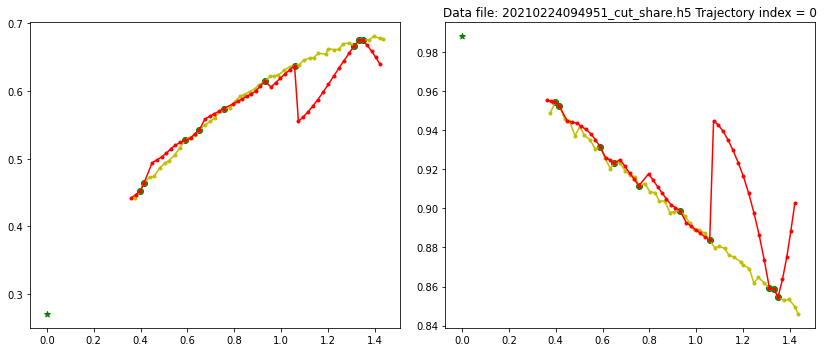

In [46]:
#demo print of interpolated trajectories
max_traj = 1

model = StepPredictor(input_size = 7, hidden_size = 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.load_state_dict(torch.load(getFullPath('StepPredictor_128h_300e.pd')))
model = model.to(device)
model.eval()

dataFile = '20210224094951_cut_share.h5'
#ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_2_cut_share.h5')], noise=False)
ds = MagicDartsDataset([getFullPath(dataFile)], noise=True)
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)

print(len(ds))
cutter = getRandomN(10, 52)
#cutter = getFixedN([29,31,40], 52)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for batch, sample in enumerate(dl):
  
  if batch == max_traj:
    break
  

  trajectory = sample['x']
  hit_point  = sample['y']
  traj_ix = sample['traj_ix'].item()

  cut_trajectory = cutter(trajectory)

  #print(ixes)
  #print(cut_trajectory)
  interp_trajectory = interpolateTrajectory(cut_trajectory.to(device), model)
  #print(cc)

  # z vs y
  axes[0].plot(trajectory[0, :, 2].to('cpu'), trajectory[0, :, 3].to('cpu'), c='y', marker='.')

  axes[0].scatter(cut_trajectory[0, :, 2].to('cpu'), cut_trajectory[0, :, 3].to('cpu'), c='g')

  axes[0].plot(interp_trajectory[0, :, 2].to('cpu'), interp_trajectory[0, :, 3].to('cpu'), c='r', marker='.')
 
  # x vs y
  axes[1].plot(trajectory[0, :, 2].to('cpu'), trajectory[0, :, 1].to('cpu'), c='y', marker='.')

  axes[1].scatter(cut_trajectory[0, :, 2].to('cpu'), cut_trajectory[0, :, 1].to('cpu'), c='g')

  axes[1].plot(interp_trajectory[0, :, 2].to('cpu'), interp_trajectory[0, :, 1].to('cpu'), c='r', marker='.')

  
  #
  axes[0].scatter([0], hit_point[0, 1], c='g', marker='*')
  axes[1].scatter([0], hit_point[0, 0], c='g', marker='*')
 

plt.title(f"Data file: {dataFile} Trajectory index = {traj_ix}")
fig.tight_layout()
plt.show()
  

In [57]:
class LSTMTrial3(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(LSTMTrial3, self).__init__()

    self.input_size = input_size 
    self.hidden_size = hidden_size
    self.output_size = output_size 
    self.num_layers = num_layers 
 
    self.fc_1 =  nn.Linear(input_size, 128) #fully connected 1
    self.fc = nn.Linear(128, output_size) #fully connected last layer
    self.bn =  nn.BatchNorm1d(52) #applying batch norm
    self.lstm = nn.LSTM(input_size=output_size, hidden_size=hidden_size,
                    num_layers=num_layers, 
                    batch_first=True, 
                    dropout=dropout) #lstm

    self.fc_out =  nn.Linear(hidden_size, output_size) #fc output
  
    self.relu = nn.ReLU() 

  def forward(self,x):

     # x[torch.isnan(x)] = 10000

      hidden = self.fc_1(x) #first Dense

      hidden = self.bn(hidden)

      hidden = self.relu(hidden) 

      #hidden = self.fc_2(hidden) #second Dense

      #hidden = self.relu(hidden) 

      hidden = self.fc(hidden) #
       
      h_0 = Variable(torch.zeros(
            self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #hidden state
      
      c_0 = Variable(torch.zeros(
          self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #internal state
    
      # Propagate input through LSTM

      output, (hn, cn) = self.lstm(hidden, (h_0, c_0)) #lstm with input, hidden, and internal state

      h = hn[-1,:,:].view(-1, self.hidden_size)
      
      out = self.fc_out(h)

      return out 

In [58]:
class LSTMTrial4(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(LSTMTrial4, self).__init__()

    self.input_size = input_size 
    self.hidden_size = hidden_size
    self.output_size = output_size 
    self.num_layers = num_layers 
 
    self.fc_1 =  nn.Linear(input_size, 128) #fully connected 1
    self.fc = nn.Linear(128, output_size) #fully connected last layer
    self.bn =  nn.BatchNorm1d(52) #applying batch norm
    self.lstm = nn.LSTM(input_size=output_size, hidden_size=hidden_size,
                    num_layers=num_layers, 
                    batch_first=True, 
                    dropout=dropout) #lstm

    self.fc_2 =  nn.Linear(hidden_size, hidden_size)

    self.fc_out =  nn.Linear(hidden_size, output_size) #fc output
  
    self.relu = nn.ReLU() 

  def forward(self,x):

     # x[torch.isnan(x)] = 10000

      hidden = self.fc_1(x) #first Dense

      hidden = self.bn(hidden)

      hidden = self.relu(hidden) 

      #hidden = self.fc_2(hidden) #second Dense

      #hidden = self.relu(hidden) 

      hidden = self.fc(hidden) #
       
      h_0 = Variable(torch.zeros(
            self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #hidden state
      
      c_0 = Variable(torch.zeros(
          self.num_layers, hidden.size(0), self.hidden_size)).to('cuda') #internal state
    
      # Propagate input through LSTM

      output, (hn, cn) = self.lstm(hidden, (h_0, c_0)) #lstm with input, hidden, and internal state

      h = hn[-1,:,:].view(-1, self.hidden_size)

      h = self.relu(h) 

      h = self.fc_2(h)
      h = self.relu(h) 


      out = self.fc_out(h)

      return out 

In [33]:
ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_1_cut_share.h5'), 
                                   getFullPath('input_para_2021_03_10_file_2_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_3_cut_share.h5'),
                                   getFullPath('input_para_2021_03_10_file_4_cut_share.h5')], noise=False)

train_size = int(0.9 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

print(len(train_dataset), len(test_dataset))

batch_size = 1000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

21600 2400


In [34]:
learning_rate = 0.0001 

input_size = 7
hidden_size = 64
num_layers = 1

output_size = 2 
dropout  = 0

model = LSTMTrial4(input_size = input_size, 
                   hidden_size = hidden_size, 
                   output_size = output_size, 
                   num_layers = num_layers, 
                   dropout = dropout)

criterion = torch.nn.MSELoss()    # mean-squared error for regression

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
num_epochs = 300

epoch_loss = []
model.train()
for epoch in range(num_epochs):
  current_loss = 0 
  for batch, sample in enumerate(train_dataloader):
    #print(sample['x'].permute(.shape)
    #print("x=", sample['x'].size())
    outputs = model.forward(sample['x'].to(device)) #forward pass
    #print("outputs=", outputs)
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    #print(outputs.shape)
    # obtain the loss function
    loss = torch.sqrt(criterion(outputs, sample['y'].to(device)))
    loss.backward() #calculates the loss of the loss function
    current_loss += loss.item()
    optimizer.step() #improve from loss, i.e backprop
    #print("loss: %1.5f" % (loss.item())) 
  epoch_loss.append(current_loss / batch_size)
  print("Epoch: %d, loss: %1.10f" % (epoch, current_loss / batch_size)) 

plt.plot(epoch_loss)
plt.show()

In [36]:
torch.save(model.state_dict(), 'drive/MyDrive/darts_data/lstm3_600ep.pd')

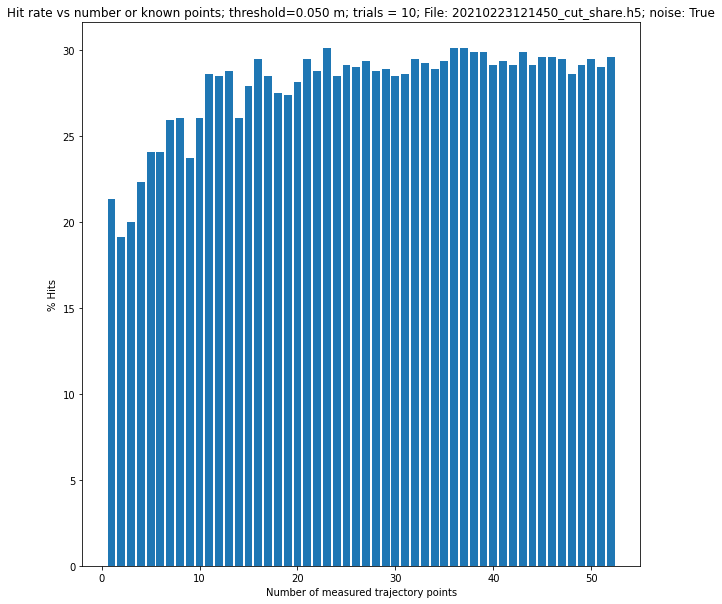

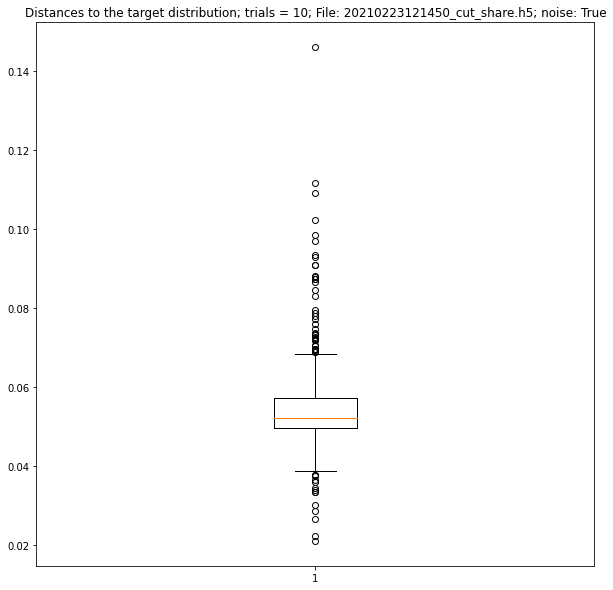

In [93]:
plot_results = False 
plt.rcParams["figure.figsize"] = (10,10)


max_traj = 100

hit_point_predictor = LSTMTrial4(input_size = 7, hidden_size = 64, output_size = 2, num_layers = 1, dropout = 0)
hit_point_predictor.load_state_dict(torch.load(getFullPath('lstm3_600ep.pd')))
hit_point_predictor = hit_point_predictor.to(device)
hit_point_predictor.eval()

step_predictor =  StepPredictor(input_size = 7, hidden_size = 128)
step_predictor.load_state_dict(torch.load(getFullPath('StepPredictor_128h_300e.pd')))
step_predictor = step_predictor.to(device)
step_predictor.eval()

#test_file = "vangel_2021_03_04_01_edited_cut_share.h5"
#"20210224094951_cut_share.h5"
test_file = "20210223121450_cut_share.h5"
noise = True

#ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_4_cut_share.h5')], noise=False)
#ds = MagicDartsDataset([getFullPath('input_para_2021_03_10_file_2_cut_share.h5')], noise=False)
#ds = MagicDartsDataset([getFullPath('vangel_2021_03_04_01_edited_cut_share.h5')], noise=True)
ds = MagicDartsDataset([getFullPath(test_file)], noise=noise)
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)
#dl = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

threshold = 0.05 
trials = 10 

hits = np.zeros(52)
misses = np.zeros(52)

for batch, sample in enumerate(dl):
  
  if batch == max_traj:
    break

  trajectory = sample['x']
  hit_point  = sample['y']

  traj_ix = sample['traj_ix'][0]

  distances = []

  traj_time = 0
  with torch.no_grad():
    for trial in range(trials):
      for n in range(1, 52+1):
        start_n_points = time.time()

        cutter = getRandomN(n, 52)
        

        cut_trajectory = cutter(trajectory)

        start = time.time()

        interp_trajectory = interpolateTrajectory(cut_trajectory.to(device), step_predictor)
        #print(cc)
        end = time.time()
        
        tt_traj_interpolation = (end - start) * 1000    
        
        start = time.time()

        predicted_hit_point = hit_point_predictor.forward(interp_trajectory.to(device))
        
        end = time.time()
        tt_hitpoint_prediction = (end - start) * 1000    

        hp_x_hat = predicted_hit_point[0,0].cpu()
        hp_z_hat = predicted_hit_point[0,1].cpu()
        hp_x = hit_point[0, 0].cpu()
        hp_z = hit_point[0, 1].cpu()

        distance = (np.sqrt((hp_x_hat - hp_x)**2 + (hp_z_hat - hp_z)**2))

        end_npoints = time.time()
    
        full_time = (end_npoints - start_n_points) * 1000
        #print(f"n = {n}, elapsed time: {full_time:.2f} ms, interpolation time: {tt_traj_interpolation:.2f} ms prediction time: {tt_hitpoint_prediction:.2f} ms")
        traj_time += full_time
        #print(distance.size())
        if distance <= threshold:
          hits[n-1]+=1
          ccolor = 'g'
        else:
          misses[n-1] +=1
          ccolor = 'r'

        distances.append(distance)
        if plot_results:
          confidence_circle = plt.Circle((hit_point[0, 0], hit_point[0, 1]), threshold, color = ccolor, fill=False)
          ax = plt.gca()
          ax.add_patch(confidence_circle)
          plt.scatter(predicted_hit_point[0, 0].cpu(), predicted_hit_point[0, 1].cpu(), c='b', marker='x')
          plt.scatter(hit_point[0, 0], hit_point[0, 1], c='r', marker='*')
    
          if n == 52:
            plt.plot([hit_point[0,0], predicted_hit_point[0, 0]], [hit_point[0, 1], predicted_hit_point[0, 1]], c='b')  

  #print(f"Trajectory time: {traj_time:.2f}ms")
  #print(hits, misses)    
if plot_results:
  plt.title(f"Traj id ={traj_ix}")
  plt.show()
  
plt.title(f"Hit rate vs number or known points; threshold={threshold:.3f} m; trials = {trials}; File: {test_file}; noise: {noise}")
plt.bar(np.arange(1, 52+1), 100 * (hits / (hits + misses))) 
plt.xlabel("Number of measured trajectory points")
plt.ylabel("% Hits")     
plt.show()

plt.boxplot(distances)
plt.title(f"Distances to the target distribution; trials = {trials}; File: {test_file}; noise: {noise}")
plt.show()


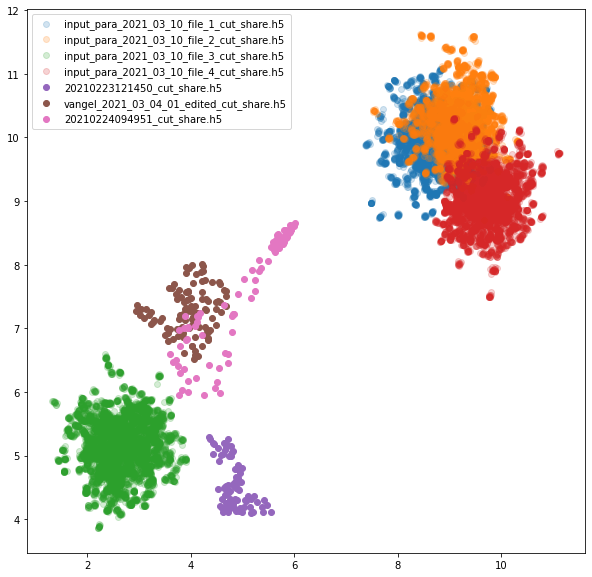

In [115]:
from sklearn.preprocessing import StandardScaler
import umap

test_files = ['input_para_2021_03_10_file_1_cut_share.h5',
              'input_para_2021_03_10_file_2_cut_share.h5',
              'input_para_2021_03_10_file_3_cut_share.h5',
              'input_para_2021_03_10_file_4_cut_share.h5',
              '20210223121450_cut_share.h5',
              'vangel_2021_03_04_01_edited_cut_share.h5',
              '20210224094951_cut_share.h5'
              ]

alphas = [0.2,0.2,0.2,0.2,1,1,1]
noise = True

reducer = umap.UMAP(n_components=15)

for test_file,alpha in zip(test_files, alphas):


  ds = MagicDartsDataset([getFullPath(test_file)], noise=noise)
  dl = DataLoader(ds, batch_size=6000, shuffle=False, num_workers=0)


  for batch, sample in enumerate(dl):
    trajectory = torch.nan_to_num(sample['x'], 0).view(-1, 52*7)
    scaled_traj = StandardScaler().fit_transform(trajectory)
    
    embeddings = reducer.fit_transform(scaled_traj)

    plt.scatter(embeddings[:,0], embeddings[:,1], label=test_file, alpha=alpha)



plt.legend()
plt.show()



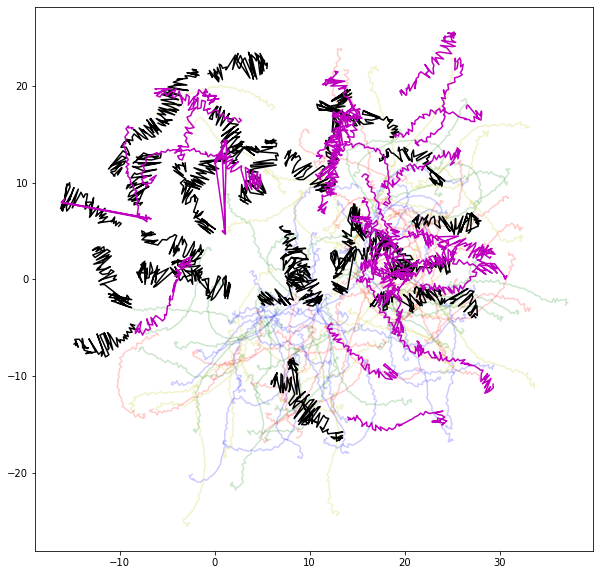

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

test_files = ['input_para_2021_03_10_file_1_cut_share.h5',
              'input_para_2021_03_10_file_2_cut_share.h5',
              'input_para_2021_03_10_file_3_cut_share.h5',
              'input_para_2021_03_10_file_4_cut_share.h5',
              '20210223121450_cut_share.h5',
              'vangel_2021_03_04_01_edited_cut_share.h5',
              '20210224094951_cut_share.h5'
              ]

alphas = [0.2,0.2,0.2,0.2,1,1,1]
colors = ['r', 'g', 'b', 'y', 'k', 'm']
noise = True

reducer = umap.UMAP() #PCA()

max_traj = 30
for test_file,alpha,c in zip(test_files, alphas, colors):


  ds = MagicDartsDataset([getFullPath(test_file)], noise=noise)
  dl = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)


  for batch, sample in enumerate(dl):
    if batch == max_traj:
      break

    trajectory = torch.nan_to_num(sample['x'], 0)[0]
    scaled_traj = StandardScaler().fit_transform(trajectory)
    
    embeddings = reducer.fit_transform(scaled_traj)

    plt.plot(embeddings[:,0], embeddings[:,1], label=test_file, alpha=alpha, c=c)



#plt.legend()
plt.show()

